# Trist'n Joseph - IST664 - Homework 2

## Set Up

In [1]:
import string
import re
import nltk
from nltk import FreqDist
from nltk.collocations import *
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import treebank

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

In [2]:
# financial articles
raw_article_text_path = open("C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST664/Assignments/Homework 1/article_text.txt")
raw_article_text = raw_article_text_path.read()

# hamlet
hamlet_text = nltk.corpus.gutenberg.raw(nltk.corpus.gutenberg.fileids( )[15])

In [3]:
def ug__regex_pattern_match(words):
    """
    """    
    ug__regex_pattern = re.compile('^[^a-z]+$')
    if (ug__regex_pattern.match(words)):
        return True
    else:
        return False
    
def bg__regex_tokenize(words):
    """
    """  
    pattern = r''' (?x)
        (?:[A-Z]\.)+
        | (?:--+)
        | \w+(?:-\w+)*        
        | \$?\d+(?:\.\d+)?%?
        | ['\".?!,:;/]+
        | [][.,;â€â€™?():-_%#â€™]
        '''
    
    tokenized_text = nltk.regexp_tokenize(words, pattern)
    
    return tokenized_text

In [4]:
def clean_text_data(raw_text):
    """
    """
    porter = nltk.PorterStemmer()
    nltkstopwords = nltk.corpus.stopwords.words('english')
    all_stopwords = nltkstopwords + ["MarketWatch", "marketwatch", "mw", "zachs", "zacks", "barron"]
    
    # need to develop different methods for unigrams vs bigrams etc
    # -- unigram
    ug__text_tokenized = nltk.word_tokenize(raw_text)
    ug__text_words = [w.lower() for w in ug__text_tokenized]
    ug__text_words = [porter.stem(word) for word in ug__text_words]
    ug__text_words_filtered = [w for w in ug__text_words if not ug__regex_pattern_match(w)]
    ug__text_words_filtered = [w for w in ug__text_words_filtered if not w in all_stopwords]
    ug__word_frequency_distribution = FreqDist(ug__text_words_filtered)
    
    # -- bigram
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bg__text_tokenized = bg__regex_tokenize(raw_text)
    bg__text_words = [w for w in bg__text_tokenized]
    
    # ---- frequencies
    bg__fnder_freq = BigramCollocationFinder.from_words(bg__text_words)
    bg__fnder_freq.apply_word_filter(ug__regex_pattern_match)
    bg__fnder_freq.apply_word_filter(lambda w: w in all_stopwords)
    bg__scored_freq = bg__fnder_freq.score_ngrams(bigram_measures.raw_freq)
    
    # ---- PMI
    bg__fnder_pmi = BigramCollocationFinder.from_words(bg__text_words)
    bg__fnder_pmi.apply_freq_filter(5)
    bg__scored_pmi = bg__fnder_pmi.score_ngrams(bigram_measures.pmi)
    
    # -- trigram
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    tg__text_tokenized = bg__regex_tokenize(raw_text)
    tg__text_words = [w for w in tg__text_tokenized]
    
    # ---- frequencies
    tg__fnder_freq = TrigramCollocationFinder.from_words(tg__text_words)
    tg__fnder_freq.apply_word_filter(ug__regex_pattern_match)
    tg__fnder_freq.apply_word_filter(lambda w: w in all_stopwords)
    tg__scored_freq = tg__fnder_freq.score_ngrams(trigram_measures.raw_freq)
    
    # ---- PMI
    tg__fnder_pmi = TrigramCollocationFinder.from_words(tg__text_words)
    tg__fnder_pmi.apply_freq_filter(5)
    tg__scored_pmi = tg__fnder_pmi.score_ngrams(trigram_measures.pmi)
    
    # -- output
    od  = {
        'unigrams': {
            'frequency': ug__word_frequency_distribution,
            'tokens': ug__text_tokenized,
            'cleaned_words': ug__text_words_filtered
        },
        'bigrams': {
            'frequency': bg__scored_freq,
            'pmi': bg__scored_pmi,
            'tokens': bg__text_tokenized
        },
        'trigrams': {
            'frequency': tg__scored_freq,
            'pmi': tg__scored_pmi, 
            'tokens': tg__text_tokenized
        }
    }
    return od

In [5]:
def tag_POS(tagging_text):
    """
    """
    # Separating the data into training and test data
    treebank_text = treebank.raw()
    treebank_tokens = treebank.words()
    treebank_tagged_words = treebank.tagged_words()
    treebank_tagged = treebank.tagged_sents()
    
    t0 = nltk.DefaultTagger('NN')
    t1 = nltk.UnigramTagger(treebank_tagged, backoff=t0)
    t2 = nltk.BigramTagger(treebank_tagged, backoff=t1)
    
    raw_text_split = nltk.sent_tokenize(tagging_text)
    text_tokenized = [bg__regex_tokenize(word) for word in raw_text_split]
    
    tagged_text = [t2.tag(tokens) for tokens in text_tokenized]
    
    tagged_text_flat = [pair for tagging_text in tagged_text for pair in tagging_text]
    
    return tagged_text_flat

## Grammar Creation (for sentence POS parsing)

### Adjectives

In [6]:
grammar_adjph = "ADJPH: {<RB.?>+<JJ.?>}"
chunk_parser_adj = nltk.RegexpParser(grammar_adjph)

### Adverbs

In [7]:
grammar_advph = "ADVPH: {<RB>+<RB>}"
chunk_parser_advph = nltk.RegexpParser(grammar_advph)

### Nouns

In [8]:
grammar_nph = "NPH: {<NNP> | <DT>+<NN.?> | <DT>+<N.?>+<P.?>+<N.?>}"
chunk_parser_nph = nltk.RegexpParser(grammar_nph)

### Verbs

In [9]:
grammar_vph = "VPH: {<VB.?>+<NNP> | <VB.?>+<DT>+<NN.?> | <VB.?>+<DT>+<N.?>+<P.?>+<N.?>}"
chunk_parser_vph = nltk.RegexpParser(grammar_vph)

## MarketWatch

In [10]:
raw_article_text_textsplit = nltk.sent_tokenize(raw_article_text)

In [11]:
article_text_tokenized = [clean_text_data(sentence)['bigrams']['tokens'] for sentence in raw_article_text_textsplit]

In [12]:
nltkstopwords = nltk.corpus.stopwords.words('english')
all_stopwords = nltkstopwords + ["MarketWatch ", "MarketWatch", "marketwatch", "mw", "zachs", "zacks", "barron"]
article_cleaned_text_tokenized = [w for w in article_text_tokenized if not w in all_stopwords]

In [13]:
article_tagged_text = [nltk.pos_tag(token) for token in article_cleaned_text_tokenized]

In [14]:
print(article_tagged_text[:5])

[[('Tesla-Hertz', 'JJ'), ('Deal', 'NNP'), ('Is', 'VBZ'), ('Great', 'NNP'), ('News', 'NNP'), ('for', 'IN'), ('Carvana', 'NNP'), ('Stock', 'NNP'), ('MarketWatch', 'NNP'), ('The', 'DT'), ('move', 'NN'), ('by', 'IN'), ('Hertz', 'NNP'), ('Global', 'NNP'), ('to', 'TO'), ('bulk', 'VB'), ('up', 'RP'), ('its', 'PRP$'), ('global', 'JJ'), ('fleet', 'NN'), ('of', 'IN'), ('rentals', 'NNS'), ('with', 'IN'), ('100', 'CD'), (',', ','), ('000', 'CD'), ('electric', 'JJ'), ('vehicles', 'NNS'), ('from', 'IN'), ('Tesla', 'NNP'), ('is', 'VBZ'), ('great', 'JJ'), ('news', 'NN'), ('for', 'IN'), ('Carvana', 'NNP'), (',', ','), ('which', 'WDT'), ('will', 'MD'), ('work', 'VB'), ('with', 'IN'), ('Hertz', 'NNP'), ('to', 'TO'), ('dispose', 'VB'), ('of', 'IN'), ('its', 'PRP$'), ('unwanted', 'JJ'), ('cars', 'NNS'), ('.', '.')], [('Tesla', 'NNP'), ('Bulls', 'NNP'), ('Are', 'NNP'), ('Hiking', 'NNP'), ('Price', 'NNP'), ('Targets', 'NNS'), ('.', '.')], [('Bears', 'NNS'), ('Are', 'VBP'), ('Holding', 'VBG'), ('Firm', 'NNP')

### Adjectives

In [15]:
# tagging the adjective phrases 
article_adjph_tags = []
for sentence in article_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_adj.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADJHP':
                article_adjph_tags.append(subtree)
                
# visualizing the adjective phrases
article_adjph_phrases = []
for phrase in article_adjph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    article_adjph_phrases.append(temp)
    
print('First 10 adjective phrases for Tesla articles are: ', article_adjph_phrases[:10])

First 10 adjective phrases for Tesla articles are:  []


In [16]:
# examining the freuqncy of the adjective phrases
article_adjph_frequency = nltk.FreqDist(article_adjph_phrases)

print('Top adjective phrases by frequency within the Tesla articles are: ')
for word, freq in article_adjph_frequency.most_common(50):
    print(word, freq)

Top adjective phrases by frequency within the Tesla articles are: 


In [17]:
# top 50 adjective tokens
article_adjective_tokens = []
for sentence in article_tagged_text:
    for word, pos in sentence:
        if pos in ['JJ', 'JJR', 'JJS']: # adjective, comparative, superlative
            if len(word) > 1:
                article_adjective_tokens.append(word)
                
article_adjective_frequency = nltk.FreqDist(article_adjective_tokens)

print('The top 50 adjectives within the Tesla articles are:')
for word, freq in article_adjective_frequency.most_common(50):
    print(word, freq)

The top 50 adjectives within the Tesla articles are:
high 97
52-week 89
all-around 88
electric 81
new 49
consecutive 46
short 43
second 40
more 38
strong 36
recent 29
great 24
higher 22
positive 22
underperforms 22
third 19
Chinese 18
other 18
big 17
first 16
global 14
latest 14
good 14
mixed 14
much 13
Big 13
last 13
More 13
next 12
rough 12
three-day 12
favorable 12
autonomous 11
automotive 11
public 11
many 11
self-driving 11
bullish 10
poor 10
own 9
little 9
Other 9
such 9
electric-vehicle 9
Self-Driving 9
all-time 8
exchange-traded 8
$1 8
few 8
best 8


In [18]:
# # calculating the average length of a adjective phrase
# article_adjph_phrases_total_length = sum(len(phrase) for phrase in article_adjph_phrases)
# article_adjph_phrases_average_length = article_adjph_phrases_total_length/len(article_adjph_phrases)

# print('The average length of an adjective phrase within the Tesla articles is ~{} words.'.format(article_adjph_phrases_average_length))

### Adverbs

In [19]:
# tagging the adverb phrases 
article_advph_tags = []
for sentence in article_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_advph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADVPH':
                article_advph_tags.append(subtree)
                
# visualizing the adverb phrases
article_advph_phrases = []
for phrase in article_advph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    article_advph_phrases.append(temp)
    
print('First 10 adverb phrases for Tesla articles are: ', article_advph_phrases[:10])

First 10 adverb phrases for Tesla articles are:  ['as soon ', 'as well ', 'pretty well ', 'also enough ', 'up almost ', 'ever so slowly ahead ', 'Not only ', 'very well ', 'not just ', 'fun again ']


In [64]:
# examining the freuqncy of the adverb phrases
article_advph_frequency = nltk.FreqDist(article_advph_phrases)
article_advph_frequency_words = []
article_advph_frequency_fs = []


print('Top adverb phrases by frequency within the Tesla articles are: ')
for word, freq in article_advph_frequency.most_common(50):
    article_advph_frequency_words.append(word)
    article_advph_frequency_fs.append(freq)
    print(word, freq)

Top adverb phrases by frequency within the Tesla articles are: 
as well  2
down again  2
as soon  1
pretty well  1
also enough  1
up almost  1
ever so slowly ahead  1
Not only  1
very well  1
not just  1
fun again  1
just yet  1
down almost  1
about much  1
right now  1
up just  1
anytime soon  1
not only  1
much lately  1
Maybe Not  1
as much  1
certainly not  1
not necessarily  1
anywhere soon  1
now very likely  1
up again  1
so much  1
out so well  1
just not  1
just maybe  1
away usually  1
Right now  1
not so  1


Text(0.5, 1.0, 'Distribution of (Top 20) Adverb Phrases, Tesla Articles')

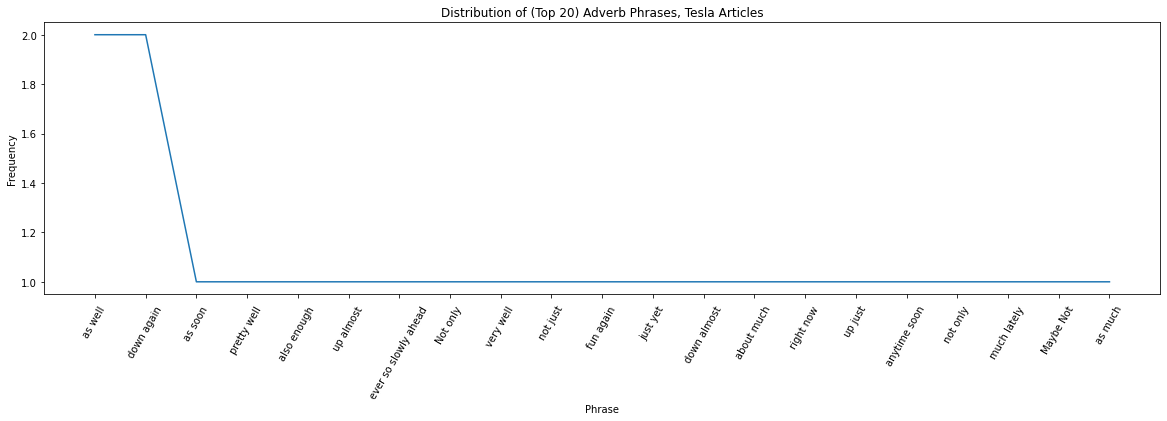

In [65]:
fig = plt.figure(figsize = (20, 5))
plt.plot(article_advph_frequency_words[:21], article_advph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Adverb Phrases, Tesla Articles')

In [21]:
# top 50 adverb tokens
article_adverb_tokens = []
for sentence in article_tagged_text:
    for word, pos in sentence:
        if pos in ['RB', 'RBR', 'RBS']: # adverb, comparative, superlative
            if len(word) > 1:
                article_adverb_tokens.append(word)
                
article_adverb_frequency = nltk.FreqDist(article_adverb_tokens)

print('The top 50 adverbs within the Tesla articles are:')
for word, freq in article_adverb_frequency.most_common(50):
    print(word, freq)

The top 50 adverbs within the Tesla articles are:
Here 40
just 28
not 25
now 24
again 21
even 19
most 17
more 16
also 16
Now 13
Not 12
still 11
ahead 10
recently 10
so 10
down 10
up 9
Still 9
back 9
as 8
soon 8
enough 8
already 8
ever 8
however 8
too 7
much 7
More 7
roughly 6
originally 6
very 6
earlier 5
about 5
well 5
only 5
Even 5
yet 5
ago 5
always 5
nearly 4
almost 4
rapidly 4
exactly 4
lately 3
Only 3
there 3
highly 3
fully 3
never 3
once 3


In [22]:
# calculating the average length of an adverb phrase
article_advph_phrases_total_length = sum(len(phrase) for phrase in article_advph_phrases)
article_advph_phrases_average_length = round(article_advph_phrases_total_length/len(article_advph_phrases), 3)

print('The average length of an adverb phrase within the Tesla articles is ~{} words.'.format(article_advph_phrases_average_length))

The average length of an adverb phrase within the Tesla articles is ~10.857 words.


### Nouns

In [23]:
# tagging the noun phrases 
article_nph_tags = []
for sentence in article_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'NPH':
                article_nph_tags.append(subtree)
                
# visualizing the noun phrases
article_nph_phrases = []
for phrase in article_nph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    article_nph_phrases.append(temp)
    
print('First 10 noun phrases for the Tesla articles are: ', article_nph_phrases[:10])

First 10 noun phrases for the Tesla articles are:  ['Deal ', 'Great ', 'News ', 'Carvana ', 'Stock ', 'MarketWatch ', 'The move ', 'Hertz ', 'Global ', 'Tesla ']


In [62]:
# examining the freuqncy of the noun phrases
article_nph_frequency = nltk.FreqDist(article_nph_phrases)
article_nph_frequency_words = []
article_nph_frequency_fs = []


print('Top noun phrases by frequency within the Tesla articles are: ')
for word, freq in article_nph_frequency.most_common(50):
    article_nph_frequency_words.append(word)
    article_nph_frequency_fs.append(freq)
    print(word, freq)

Top noun phrases by frequency within the Tesla articles are: 
MarketWatch  431
Tesla  375
the stock  152
Stock  138
Inc  135
Co  129
the company  114
Ford  102
Jones  94
Industrial  93
Average  93
Index  93
General  90
DJIA  88
NIO  87
Motor  84
Shares  80
Group  72
Musk  71
Workhorse  69
ADR  66
EV  65
P  63
Elon  60
Thursday  55
China  54
the Dow  54
Wednesday  53
the S  51
Monday  50
Tuesday  48
Composite  48
Friday  45
the NASDAQ  45
COMP  45
SPX  43
Bitcoin  42
GM  41
Dow  38
CEO  38
U.S.  38
Is  32
Cathie  31
Wood  31
ARK  27
The stock  26
Stocks  25
February  24
April  23
WKHS  23


Text(0.5, 1.0, 'Distribution of (Top 20) Noun Phrases, Tesla Articles')

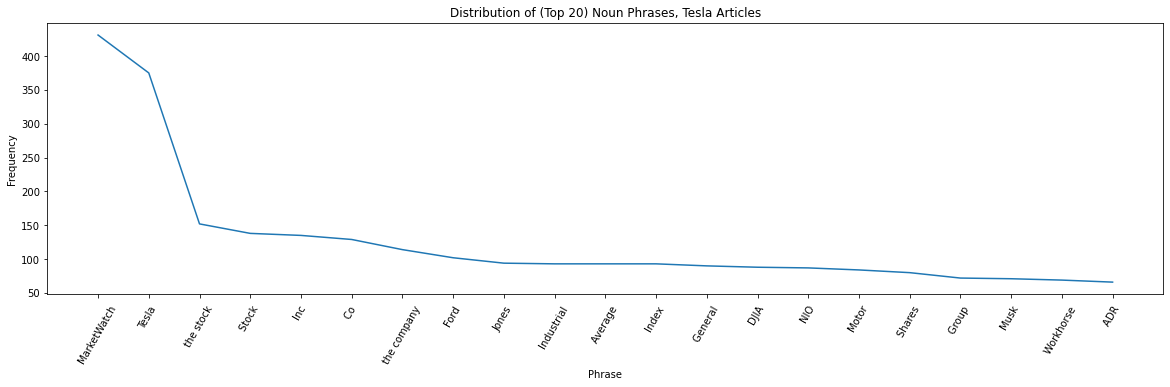

In [63]:
fig = plt.figure(figsize = (20, 5))
plt.plot(article_nph_frequency_words[:21], article_nph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Noun Phrases, Tesla Articles')

In [25]:
# top 50 noun tokens
article_noun_tokens = []
for sentence in article_tagged_text:
    for word, pos in sentence:
        if pos in ['NN', 'NNS', 'NNP', 'NNPS']:
            if len(word) > 1:
                article_noun_tokens.append(word)
                
article_noun_frequency = nltk.FreqDist(article_noun_tokens)

print('The top 50 nouns within the Tesla articles are:')
for word, freq in article_noun_frequency.most_common(50):
    print(word, freq)

The top 50 nouns within the Tesla articles are:
MarketWatch 463
Tesla 395
stock 316
market 195
Stock 171
company 155
trading 141
Inc 135
Co 129
NIO 109
day 107
Ford 103
Dow 99
Motors 95
Jones 94
Industrial 93
Average 93
Index 93
General 90
session 89
DJIA 88
EV 85
Shares 85
Motor 84
ADR 80
Group 72
investors 71
Musk 71
Workhorse 69
Elon 60
vehicles 56
Thursday 55
China 55
Wednesday 53
vehicle 53
Monday 50
U.S. 49
Tuesday 48
Composite 48
Friday 45
NASDAQ 45
COMP 45
Stocks 44
Bitcoin 44
SPX 43
maker 41
GM 41
auto 40
CEO 38
stocks 38


In [26]:
# calculating the average length of a noun phrase
article_nph_phrases_total_length = sum(len(phrase) for phrase in article_nph_phrases)
article_nph_phrases_average_length = round(article_nph_phrases_total_length/len(article_nph_phrases), 3)

print('The average length of a noun phrase within the Tesla articles is ~{} words.'.format(article_nph_phrases_average_length))

The average length of a noun phrase within the Tesla articles is ~7.331 words.


### Verbs

In [27]:
# tagging the verb phrases 
article_vph_tags = []
for sentence in article_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_vph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'VPH':
                article_vph_tags.append(subtree)
                
# visualizing the verb phrases
article_vph_phrases = []
for phrase in article_vph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    article_vph_phrases.append(temp)
    
print('First 10 verb phrases for the Tesla articles are: ', article_vph_phrases[:10])

First 10 verb phrases for the Tesla articles are:  ['Is Great ', 'Are Holding Firm ', 'is a Tesla ', 'means the Tesla ', 'unveiled a proposal ', 'fund President ', 's ARK ', 'Get Their ', 'MarketWatch The Dow ', 'made a run ']


In [60]:
# examining the freuqncy of the verb phrases
article_vph_frequency = nltk.FreqDist(article_vph_phrases)
article_vph_frequency_words = []
article_vph_frequency_fs = []

print('Top verb phrases by frequency within the Tesla articles are: ')
for word, freq in article_vph_frequency.most_common(50):
    article_vph_frequency_words.append(word)
    article_vph_frequency_fs.append(freq)
    print(word, freq)

Top verb phrases by frequency within the Tesla articles are: 
was the stock  36
was the ADR  9
falls Monday  6
s Elon  4
s another sign  4
s ARK  3
falls Thursday  3
MarketWatch The Dow  2
s the Math  2
Is Getting Into  2
MarketWatch The electric-vehicle  2
Give Tesla  2
has a problem  2
delivered a record  2
Is Up  2
give Tesla  2
MarketWatch A  2
said Tuesday  2
involving Tesla  2
Reported Record  2
including Tesla  2
joined the S  2
means Tesla  2
falls Wednesday  2
falls Tuesday  2
Dropping Again  2
Is Great  1
Are Holding Firm  1
is a Tesla  1
means the Tesla  1
unveiled a proposal  1
fund President  1
Get Their  1
made a run  1
Dives Into  1
Are the Winners  1
are jumping a lot  1
including Boeing  1
pushed the car  1
pushing the company  1
reach that valuation  1
MarketWatch The move  1
have risen this year  1
Hosted A  1
Revealed Three  1
hosted a technology  1
showcased some things  1
s a setback  1
Took Off  1
Bought Moderna  1


Text(0.5, 1.0, 'Distribution of (Top 20) Verb Phrases, Tesla Articles')

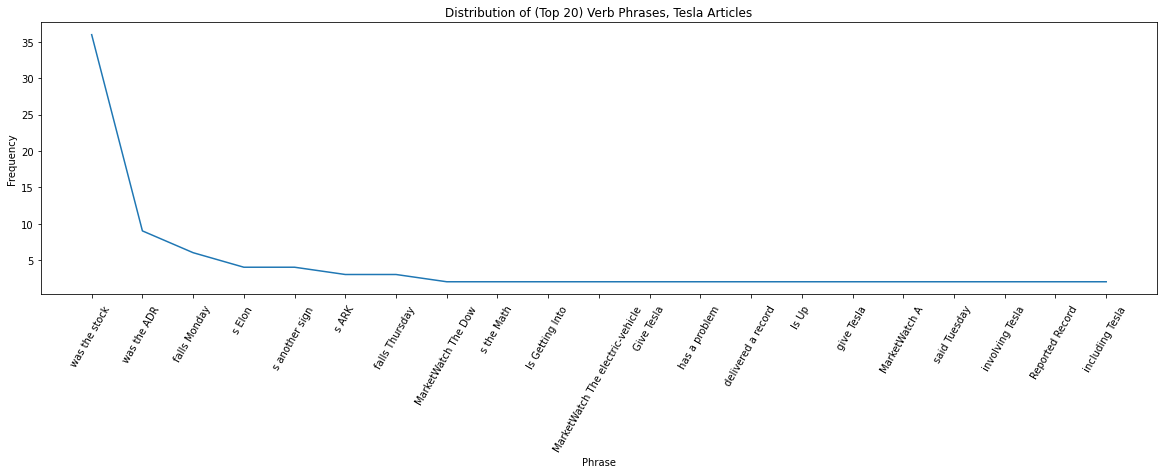

In [61]:
fig = plt.figure(figsize = (20, 5))
plt.plot(article_vph_frequency_words[:21], article_vph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Verb Phrases, Tesla Articles')

In [29]:
# top 50 verb tokens
article_verb_tokens = []
for sentence in article_tagged_text:
    for word, pos in sentence:
        if pos in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            if len(word) > 1:
                article_verb_tokens.append(word)
                
article_verb_frequency = nltk.FreqDist(article_verb_tokens)

print('The top 50 verbs within the Tesla articles are:')
for word, freq in article_verb_frequency.most_common(50):
    print(word, freq)

The top 50 verbs within the Tesla articles are:
is 185
be 174
rising 102
are 95
Is 88
closed 88
proved 88
falling 84
was 74
has 72
achieved 49
reached 41
outperforms 40
MarketWatch 39
have 36
Are 31
were 25
snapped 24
going 20
rallied 17
been 16
getting 16
had 15
said 15
reported 14
rise 14
rose 13
hit 13
falls 13
make 12
compared 12
inched 12
get 11
advanced 11
shed 11
isn 10
sold 10
Have 10
coming 10
Be 10
know 10
do 10
don 10
slid 10
means 9
made 9
wants 9
including 9
go 9
appeared 9


In [30]:
# calculating the average length of a verb phrase
article_vph_phrases_total_length = sum(len(phrase) for phrase in article_vph_phrases)
article_vph_phrases_average_length = round(article_vph_phrases_total_length/len(article_vph_phrases), 3)

print('The average length of a verb phrase within the Tesla articles is ~{} words.'.format(article_vph_phrases_average_length))

The average length of a verb phrase within the Tesla articles is ~15.29 words.


## Hamlet

In [31]:
hamlet_text_textsplit = nltk.sent_tokenize(hamlet_text)
number_of_hamlet_sentences = len(hamlet_text_textsplit)

In [32]:
hamlet_text_tokenized = [clean_text_data(sentence)['bigrams']['tokens'] for sentence in hamlet_text_textsplit]
hamlet_cleaned_text_tokenized = [w for w in hamlet_text_tokenized if not w in all_stopwords]

In [33]:
hamlet_tagged_text = [nltk.pos_tag(token) for token in hamlet_cleaned_text_tokenized]

In [34]:
print(hamlet_tagged_text[:5])

[[('[', 'IN'), ('The', 'DT'), ('Tragedie', 'NNP'), ('of', 'IN'), ('Hamlet', 'NNP'), ('by', 'IN'), ('William', 'NNP'), ('Shakespeare', 'NNP'), ('1599', 'CD'), (']', 'NNP'), ('Actus', 'NNP'), ('Primus', 'NNP'), ('.', '.')], [('Scoena', 'NNP'), ('Prima', 'NNP'), ('.', '.')], [('Enter', 'NNP'), ('Barnardo', 'NNP'), ('and', 'CC'), ('Francisco', 'NNP'), ('two', 'CD'), ('Centinels', 'NNP'), ('.', '.')], [('Barnardo', 'NNP'), ('.', '.')], [('Who', 'WP'), ("'", "''"), ('s', 'NN'), ('there', 'RB'), ('?', '.')]]


### Adjectives

In [35]:
hamlet_adjph_tags = []
for sentence in hamlet_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_adj.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADJHP':
                hamlet_adjph_tags.append(subtree)
                
# visualizing the adjective phrases
hamlet_adjph_phrases = []
for phrase in hamlet_adjph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    hamlet_adjph_phrases.append(temp)
    
print('First 10 adjective phrases for Hamlet are: ', hamlet_adjph_phrases[:10])

First 10 adjective phrases for Hamlet are:  []


In [36]:
# examining the freuqncy of the adjective phrases
hamlet_adjph_frequency = nltk.FreqDist(hamlet_adjph_phrases)

print('Top adjective phrases by frequency within Hamlet are: ')
for word, freq in hamlet_adjph_frequency.most_common(50):
    print(word, freq)

Top adjective phrases by frequency within Hamlet are: 


In [37]:
# top 50 adjective tokens
hamlet_adjective_tokens = []
for sentence in hamlet_tagged_text:
    for word, pos in sentence:
        if pos in ['JJ', 'JJR', 'JJS']: # adjective, comparative, superlative
            if len(word) > 1:
                hamlet_adjective_tokens.append(word)
                
hamlet_adjective_frequency = nltk.FreqDist(hamlet_adjective_tokens)

print('The top 50 adjectives within Hamlet are:')
for word, freq in hamlet_adjective_frequency.most_common(50):
    print(word, freq)

The top 50 adjectives within Hamlet are:
good 76
thy 55
more 38
such 34
most 30
much 27
dead 25
Good 22
true 21
thou 20
great 19
owne 17
old 16
other 15
mine 15
many 15
sweet 14
same 13
Most 12
deere 12
Noble 12
mad 12
Other 12
thee 11
last 11
farre 10
first 10
little 10
second 10
strange 9
young 9
full 9
late 9
excellent 9
free 9
selfe 8
welcome 8
seene 8
haue 8
whole 8
better 8
common 8
best 8
vs 8
againe 7
oft 7
long 7
fine 7
bad 7
hot 6


In [38]:
# # calculating the average length of an adjective phrase
# hamlet_adjph_phrases_total_length = sum(len(phrase) for phrase in hamlet_adjph_phrases)
# hamlet_adjph_phrases_average_length = round(hamlet_adjph_phrases_total_length/len(hamlet_adjph_phrases), 3)

# print('The average length of an adjective phrase within Hamlet is ~{} words.'.format(hamlet_adjph_phrases_average_length))

### Adverbs

In [39]:
# tagging the adverb phrases 
hamlet_advph_tags = []
for sentence in hamlet_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_advph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADVPH':
                hamlet_advph_tags.append(subtree)
                
# visualizing the adverb phrases
hamlet_advph_phrases = []
for phrase in hamlet_advph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    hamlet_advph_phrases.append(temp)
    
print('First 10 adverb phrases for Hamlet are: ', hamlet_advph_phrases[:10])

First 10 adverb phrases for Hamlet are:  ['spoke too ', 'Thus twice before ', 'doth well ', 'Thus much ', 'Not so ', 'not alone ', 'too too ', 'not so much ', 'too roughly ', 'not well ']


In [58]:
# examining the freuqncy of the adverb phrases
hamlet_advph_frequency = nltk.FreqDist(hamlet_advph_phrases)
hamlet_advph_frequency_words = []
hamlet_advph_frequency_fs = []

print('Top adverb phrases by frequency within Hamlet are: ')
for word, freq in hamlet_advph_frequency.most_common(50):
    hamlet_advph_frequency_words.append(word)
    hamlet_advph_frequency_fs.append(freq)
    print(word, freq)

Top adverb phrases by frequency within Hamlet are: 
not well  4
not so  4
not alone  2
thee well  2
very well  2
So much  2
too much  2
so well  2
spoke too  1
Thus twice before  1
doth well  1
Thus much  1
Not so  1
too too  1
not so much  1
too roughly  1
else neere  1
too long  1
not then  1
so cleerely  1
so much  1
very cold  1
natiue heere  1
So horridly  1
So art  1
thou poore  1
so helpe  1
so ere  1
so poore  1
so ranke  1
so quaintly  1
beene so  1
vs well  1
very neere  1
euen poore  1
not craft enough  1
so heauenly  1
no longer then  1
not better  1
not yet  1
so indeed  1
Very well  1
amaze indeed  1
so bestow  1
right well  1
well enough  1
quickly too  1
not too  1
so abhominably  1
So long  1


Text(0.5, 1.0, 'Distribution of (Top 20) Adverb Phrases, Hamlet')

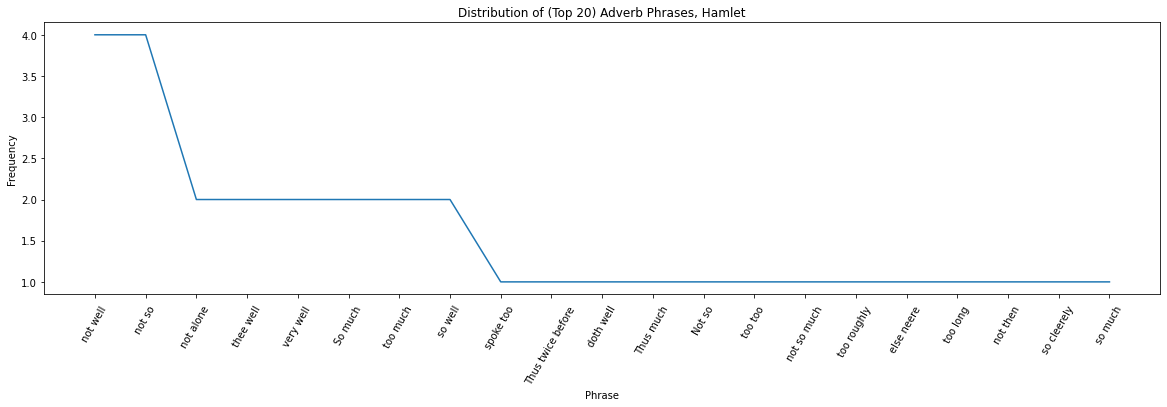

In [59]:
fig = plt.figure(figsize = (20, 5))
plt.plot(hamlet_advph_frequency_words[:21], hamlet_advph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Adverb Phrases, Hamlet')

In [41]:
# top 50 adverb tokens
hamlet_adverb_tokens = []
for sentence in hamlet_tagged_text:
    for word, pos in sentence:
        if pos in ['RB', 'RBR', 'RBS']: # adverb, comparative, superlative
            if len(word) > 1:
                hamlet_adverb_tokens.append(word)
                
hamlet_adverb_frequency = nltk.FreqDist(hamlet_adverb_tokens)

print('The top 50 adverbs within Hamlet are:')
for word, freq in hamlet_adverb_frequency.most_common(50):
    print(word, freq)

The top 50 adverbs within Hamlet are:
not 286
so 139
then 75
now 68
too 55
well 53
more 45
very 44
most 35
So 33
Then 33
thus 33
heere 25
Now 24
yet 24
there 20
away 20
indeed 18
as 18
once 17
Not 14
much 14
still 14
else 13
Well 9
alone 9
Indeed 9
long 7
further 7
together 7
therefore 7
neuer 7
better 7
Thus 6
ere 6
enough 6
neere 6
here 6
almost 6
first 6
freely 5
poore 5
thee 5
presently 5
twice 4
sometimes 4
Therefore 4
truly 4
longer 4
Very 4


In [42]:
# calculating the average length of an adverb phrase
hamlet_advph_phrases_total_length = sum(len(phrase) for phrase in hamlet_advph_phrases)
hamlet_advph_phrases_average_length = round(hamlet_advph_phrases_total_length/len(hamlet_advph_phrases), 3)

print('The average length of an adverb phrase within Hamlet is ~{} words.'.format(hamlet_advph_phrases_average_length))

The average length of an adverb phrase within Hamlet is ~10.419 words.


### Nouns

In [43]:
# tagging the noun phrases 
hamlet_nph_tags = []
for sentence in hamlet_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'NPH':
                hamlet_nph_tags.append(subtree)
                
# visualizing the adverb phrases
hamlet_nph_phrases = []
for phrase in hamlet_nph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    hamlet_nph_phrases.append(temp)
    
print('First 10 adverb phrases for Hamlet are: ', hamlet_nph_phrases[:10])

First 10 adverb phrases for Hamlet are:  ['The Tragedie ', 'Hamlet ', 'William ', 'Shakespeare ', '] ', 'Actus ', 'Primus ', 'Scoena ', 'Prima ', 'Enter ']


In [56]:
# examining the freuqncy of the noun phrases
hamlet_nph_frequency = nltk.FreqDist(hamlet_nph_phrases)
hamlet_nph_frequency_words = []
hamlet_nph_frequency_fs = []

print('Top noun phrases by frequency Hamlet are: ')
for word, freq in hamlet_nph_frequency.most_common(50):
    hamlet_nph_frequency_words.append(word)
    hamlet_nph_frequency_fs.append(freq)
    print(word, freq)

Top noun phrases by frequency Hamlet are: 
Ham  328
Lord  203
King  118
Hamlet  97
Hor  94
Enter  66
Qu  61
Ile  58
Laer  58
Pol  48
Sir  44
Rosin  42
Horatio  40
Polon  37
Heauen  34
Father  34
the King  33
O  32
Mar  31
Ophe  31
Tis  29
Ophelia  28
Mother  28
Clo  28
Come  26
Nay  25
God  23
Exeunt  23
Queene  23
Polonius  20
Guild  20
England  20
Giue  19
Denmarke  19
Which  18
Loue  18
Osr  18
Haue  17
Guildensterne  17
Sonne  16
Nature  15
A  15
Be  14
Kin  14
Thou  13
Ghost  13
Gertrude  13
Laertes  13
Reynol  13
the matter  13


Text(0.5, 1.0, 'Distribution of (Top 20) Noun Phrases, Hamlet')

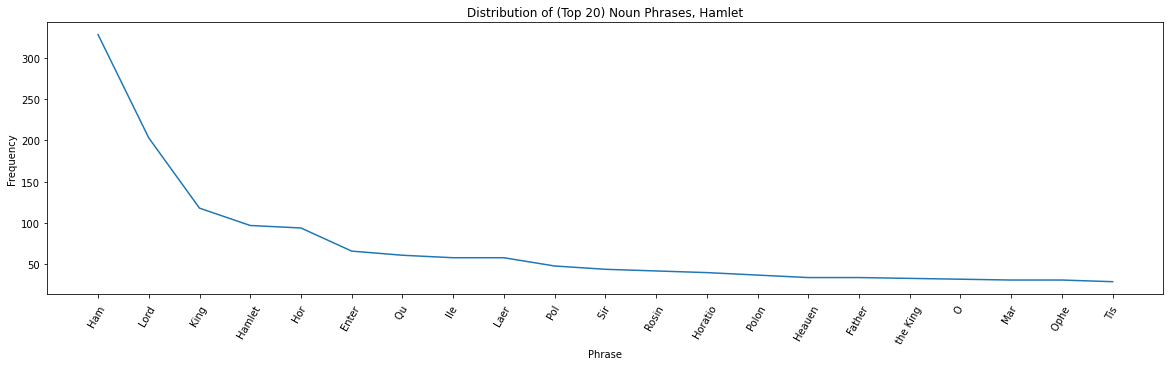

In [57]:
fig = plt.figure(figsize = (20, 5))
plt.plot(hamlet_nph_frequency_words[:21], hamlet_nph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Noun Phrases, Hamlet')

In [45]:
# top 50 noun tokens
hamlet_noun_tokens = []
for sentence in hamlet_tagged_text:
    for word, pos in sentence:
        if pos in ['NN', 'NNS', 'NNP', 'NNPS']:
            if len(word) > 1:
                hamlet_noun_tokens.append(word)
                
hamlet_noun_frequency = nltk.FreqDist(hamlet_noun_tokens)

print('The top 50 nouns within Hamlet are:')
for word, freq in hamlet_noun_frequency.most_common(50):
    print(word, freq)

The top 50 nouns within Hamlet are:
Ham 333
Lord 211
King 170
Hamlet 98
Hor 95
Enter 80
Qu 62
Laer 59
Ile 58
Ophe 55
Pol 48
Sir 47
thou 45
Father 45
vs 43
Rosin 43
th 42
man 42
Horatio 40
Queene 39
Polon 38
time 37
Mother 37
thee 36
Heauen 36
death 36
selfe 35
Mar 31
Tis 30
life 30
night 29
tis 29
loue 29
Clo 29
Laertes 28
Ophelia 28
Come 26
Nay 25
thing 25
God 25
hath 25
Play 25
heart 24
againe 24
vp 24
matter 24
nothing 23
Exeunt 23
world 22
Ghost 21


In [46]:
# calculating the average length of a noun phrase
hamlet_nph_phrases_total_length = sum(len(phrase) for phrase in hamlet_nph_phrases)
hamlet_nph_phrases_average_length = round(hamlet_nph_phrases_total_length/len(hamlet_nph_phrases), 3)

print('The average length of a noun phrase within Hamlet is ~{} words.'.format(hamlet_nph_phrases_average_length))

The average length of a noun phrase within Hamlet is ~7.225 words.


In [47]:
print(hamlet_nph_phrases[:10])

['The Tragedie ', 'Hamlet ', 'William ', 'Shakespeare ', '] ', 'Actus ', 'Primus ', 'Scoena ', 'Prima ', 'Enter ']


In [48]:
# # calculating the portion of noun phrases within the corpus
# number_of_hamlet_nph_phrases = len(hamlet_nph_phrases)
# hamlet_nph_phrases_proporation = round(number_of_hamlet_nph_phrases * 100/number_of_hamlet_sentences, 3)

# print('Noun phrases account for ~{}% of sentences within Hamlet.'.format(hamlet_nph_phrases_proporation))

### Verbs

In [49]:
# tagging the verb phrases 
hamlet_vph_tags = []
for sentence in hamlet_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_vph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'VPH':
                hamlet_vph_tags.append(subtree)
                
# visualizing the verb phrases
hamlet_vph_phrases = []
for phrase in hamlet_vph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    hamlet_vph_phrases.append(temp)
    
print('First 10 verb phrases for Hamlet are: ', hamlet_vph_phrases[:10])

First 10 verb phrases for Hamlet are:  ['liue the King ', 'bed Francisco ', 'do meet Horatio ', 'is Horatio ', 'watch the minutes ', 'heare Barnardo ', 'art a Scholler ', 'buried Denmarke ', 'is offended Barn ', 'answer Barn ']


In [50]:
# examining the freuqncy of the verb phrases
hamlet_vph_frequency = nltk.FreqDist(hamlet_vph_phrases)
hamlet_vph_frequency_words = []
hamlet_vph_frequency_fs = []

print('Top verb phrases by frequency Hamlet are: ')
for word, freq in hamlet_vph_frequency.most_common(50):
    hamlet_vph_frequency_words.append(word)
    hamlet_vph_frequency_fs.append(freq)
    print(word, freq)

Top verb phrases by frequency Hamlet are: 
is the matter  3
s the newes  2
thy Mother  2
stand an end  2
s the matter  2
vse no Art  2
haue a daughter  2
speake Guil  2
haue Newes  2
cannot Ham  2
kill a King  2
is the poyson  2
be King  2
go Gertrude  2
is no matter  2
liue the King  1
bed Francisco  1
do meet Horatio  1
is Horatio  1
watch the minutes  1
heare Barnardo  1
art a Scholler  1
buried Denmarke  1
is offended Barn  1
answer Barn  1
toyles the subiect  1
diuide the Sunday  1
make the Night  1
slay this Fortinbras  1
hath a stomacke  1
hast any sound  1
thy Countries  1
stand Barn  1
is the Trumpet  1
erring Spirit  1
comes Wherein  1
singeth all night  1
is the time  1
re the dew  1
weighing Delight  1
Holding a weake  1
Importing the surrender  1
is the Throne  1
thy Father  1
sayes Pollonius  1
go King  1
kinde King  1
lost a Father  1
is a course  1
tis a fault  1


Text(0.5, 1.0, 'Distribution of (Top 20) Verb Phrases, Hamlet')

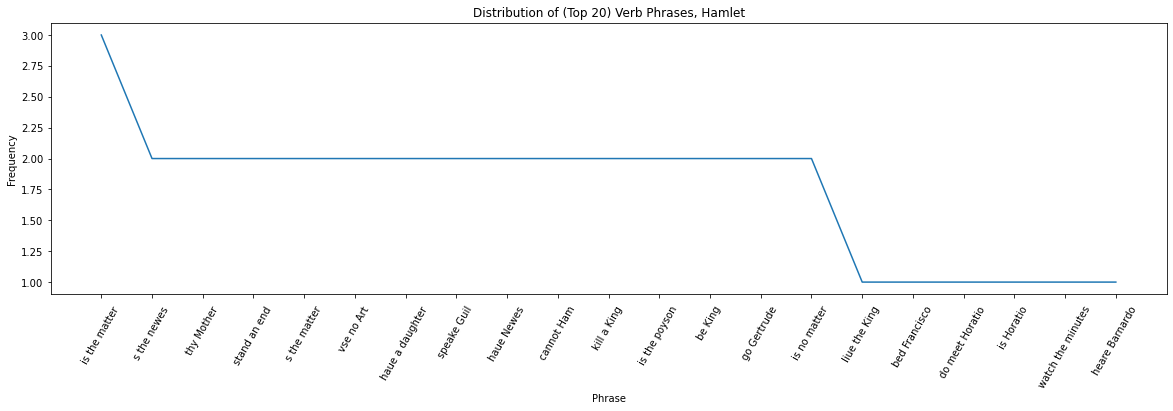

In [51]:
fig = plt.figure(figsize = (20, 5))
plt.plot(hamlet_vph_frequency_words[:21], hamlet_vph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Verb Phrases, Hamlet')

In [52]:
# top 50 verb tokens
hamlet_verb_tokens = []
for sentence in hamlet_tagged_text:
    for word, pos in sentence:
        if pos in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            if len(word) > 1:
                hamlet_verb_tokens.append(word)
                
hamlet_verb_frequency = nltk.FreqDist(hamlet_verb_tokens)

print('The top 50 verb within Hamlet are:')
for word, freq in hamlet_verb_frequency.most_common(50):
    print(word, freq)

The top 50 verb within Hamlet are:
is 304
be 175
haue 129
are 113
do 82
was 77
know 68
come 62
let 61
did 52
am 50
make 44
see 44
say 43
Let 40
had 38
tell 38
speake 37
go 35
doe 34
thinke 30
made 29
giue 27
were 24
comes 22
Is 21
done 21
cannot 21
take 20
hold 20
set 20
put 20
hath 19
selfe 19
heare 18
thou 17
pray 17
does 17
call 17
makes 14
gone 13
thy 13
Do 13
saw 13
said 13
sent 13
goes 12
finde 12
play 12
bee 12


In [53]:
# calculating the average length of a verb phrase
hamlet_vph_phrases_total_length = sum(len(phrase) for phrase in hamlet_vph_phrases)
hamlet_vph_phrases_average_length = round(hamlet_vph_phrases_total_length/len(hamlet_vph_phrases), 3)

print('The average length of a verb phrase within Hamlet is ~{} words.'.format(hamlet_vph_phrases_average_length))

The average length of a verb phrase within Hamlet is ~14.599 words.


In [54]:
# # calculating the portion of verb phrases within the corpus
# number_of_hamlet_vph_phrases = len(hamlet_vph_phrases)
# hamlet_vph_phrases_proporation = round(number_of_hamlet_vph_phrases * 100/number_of_hamlet_sentences, 3)

# print('Verb phrases account for ~{}% of sentences within Hamlet.'.format(hamlet_vph_phrases_proporation))

In [55]:
print(hamlet_vph_phrases[:3])

hamlet_whole_sentences = []

# loop over the sentences in the adjective phrase sentences we created:
for sents in hamlet_vph_tags:
    temp=''
    for (word,tag) in sents:
        temp += word+' '
    hamlet_whole_sentences.append(temp)

        
print(hamlet_whole_sentences[:3])

['liue the King ', 'bed Francisco ', 'do meet Horatio ']
['liue the King ', 'bed Francisco ', 'do meet Horatio ']
